# Analyzing Factors Influencing Contestant Performance on American Idol

#### Kaitlin Fernon

### Introduction

#### The Popularity of TV Show Competitions

Television show competitions have captivated audiences for decades, becoming a significant part of popular culture. Shows like "American Idol," "The Voice," and "The Bachelor" draw millions of viewers each season, all eager to see which contestants will rise to the top. These shows not only provide entertainment but also offer a platform for talented individuals to showcase their skills and potentially launch successful careers.

Understanding the factors that influence performance in TV show competitions can provide valuable insights for contestants aiming to improve their chances of success and for producers looking to enhance the show’s appeal. This tutorial aims to explore the factors contributing to contestant performance on "American Idol" using data science techniques, guiding the reader through data curation, exploratory data analysis, hypothesis testing, and machine learning to extract meaningful insights.

#### Dataset Overview

For this analysis, we will use a dataset containing information about various contestants in a TV show competition. The dataset includes features such as contestant ratings, state of origin, number of episodes participated in, and other relevant metrics. By examining this dataset, we can identify patterns and correlations that might explain what contributes to a contestant's success or failure.

In [27]:
# Imports
import requests
from bs4 import BeautifulSoup
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from mlxtend.feature_selection import SequentialFeatureSelector
import numpy as np
from sklearn.metrics import r2_score
import warnings

# Suppress specific FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning, module='sklearn.model_selection._validation')

### Data Curation, Parsing, and Management

Data curation is the first and crucial step in any data science project. It involves cleaning and organizing the data to make it suitable for analysis. Let's begin by loading our dataset and inspecting its structure.

#### Loading in the Data

##### Get data from Ratings tab on the database

In [28]:
# Define the url
base_url = "https://whatnottosing.com/contestants.asp?dset=rat&pg=100&sort=con&filter=all&st="
suffix = "#co"

# There are 559 entries, 100 entries per page, so 6 total pages
total_pages = 6

# List to store all rows
all_rows = []

# Loop through each page and extract data
for pg in range(1, total_pages + 1):
    url = base_url + str(pg) + suffix
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the table
    table = soup.find('table', {'class': 'wntsTable contestants'})

    if table:
        # Get all rows within tbody except the header
        tbody = table.find('tbody')
        if tbody:
            rows = tbody.find_all('tr')

            if not rows:
                print(f"No rows found on page {pg}")
            else:
                for i in range(0, len(rows), 2):
                    row = rows[i] # find_all('tr') is picking up subtable in ratings column, skip those
                    cols = row.find_all('td')
                    cols = [col.text.strip() for col in cols]

                    # Extract Name / Hometown and Ssn data
                    name_hometown_data = cols[1].split('\n')
                    name_hometown = name_hometown_data[1].strip() if len(name_hometown_data) > 1 else ''
                    name = row.find('a', {'class': 'contestant'}).text.strip()
                    hometown = row.find('div', {'class': 'contestantHometown'}).text.strip()

                    # Format the season data
                    ssn = row.find('div', {'class': 'seasonName'}).text.strip()
                    split_index = ssn.index("A")
                    season = ssn[split_index:] # Remove numbers before AI
                    season = season[2:] # Remove AI characters, get raw number

                    # Format the place data
                    season_place = cols[3].split('\n')
                    place = season_place[0].strip()

                    # Extract the rating value
                    rating_element = row.find('td', {'class': 'ratingNumber'})
                    rating = rating_element.text.strip() if rating_element else None

                    # Append cleaned data
                    all_rows.append([cols[0], name, hometown, season, place, rating] + cols[5:])

        else:
            print(f"No tbody found in table on page {pg}")

    else:
        print(f"Table not found on page {pg}")

# Create dataframe
if all_rows:
    columns = ['ID', 'Name', 'Hometown', 'Ssn', 'Plc', 'Rtg.', 'Rtg. copy', 'n/a', '#Ep', '#Pf', 'Hi', 'Lo', 'Std', '1-star', '2-star', '3-star', '4-star', '5-star']
    ratings = pd.DataFrame(all_rows, columns = columns)
else:
    print("No data collected. Please check the table structure or the URL.")

# Remove unnecessary columns
ratings = ratings.drop(columns=['Rtg. copy', 'n/a'])

ratings.head()

,ID,Name,Hometown,Ssn,Plc,Rtg.,#Ep,#Pf,Hi,Lo,Std,1-star,2-star,3-star,4-star,5-star
0,1,Christopher Aaron,"Duluth, GA",1,200 SF,40.0,2,2,49,31,20.5,0,1,1,0,0
1,2,Casey Abrams,"Wilmette, IL",10,6,56.8,9,10,88,37,22.5,0,3,2,4,1
2,3,Amy Adams,"Bakersfield, CA",3,10,61.0,4,4,89,38,16.5,0,1,1,1,1
3,4,J.D. Adams,"Burbank, CA",2,200 SF,35.0,1,1,35,35,21.0,0,1,0,0,0
4,5,Naima Adedapo,"Milwaukee, WI",10,10,46.7,6,6,73,14,20.2,1,1,1,3,0


##### Get data from Extended Data tab on the database

In [29]:
# Define the url
base_url = "https://whatnottosing.com/contestants.asp?dset=ext&pg=100&sort=con&filter=all&st="
suffix = "#co"
# There are 559 entries, 100 entries per page, so 6 total pages
total_pages = 6

# List to store all rows
all_rows = []

# Loop through each page and extract data
for pg in range(1, total_pages + 1):
    url = base_url + str(pg) + suffix
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the table
    table = soup.find('table', {'class': 'wntsTable contestants'})

    if table:
        # Get all rows within tbody except the header
        tbody = table.find('tbody')
        if tbody:
            rows = tbody.find_all('tr')

            if not rows:
                print(f"No rows found on page {pg}")
            else:
                for row in rows:
                    cols = row.find_all('td')
                    cols = [col.text.strip() for col in cols]

                    # Extract Name / Hometown and Ssn data
                    name_hometown_data = cols[1].split('\n')
                    name_hometown = name_hometown_data[1].strip() if len(name_hometown_data) > 1 else ''
                    name = row.find('a', {'class': 'contestant'}).text.strip()
                    hometown = row.find('div', {'class': 'contestantHometown'}).text.strip()

                    # Format the season data
                    ssn = row.find('div', {'class': 'seasonName'}).text.strip()
                    split_index = ssn.index("A")
                    season = ssn[split_index:] # Remove numbers before AI
                    season = season[2:] # Remove AI characters, get raw number

                    # Format the place data
                    season_place = cols[3].split('\n')
                    place = season_place[0].strip()

                    # Append cleaned data
                    all_rows.append([cols[0], name, name_hometown, season, place] + cols[4:])

        else:
            print(f"No tbody found in table on page {pg}")

    else:
        print(f"Table not found on page {pg}")

# Create dataframe
if all_rows:
    columns = ['ID', 'Name', 'Hometown', 'Ssn', 'Plc', 'Rtg.', 'SF', 'FI', 'Solo', 'Lo1', 'Growth', '#Ep.', 'B3', 'SAge', 'FF', 'RF']
    extended = pd.DataFrame(all_rows, columns = columns)
else:
    print("No data collected. Please check the table structure or the URL.")

extended.head()

,ID,Name,Hometown,Ssn,Plc,Rtg.,SF,FI,Solo,Lo1,Growth,#Ep.,B3,SAge,FF,RF
0,1,Christopher Aaron,"Duluth, GA",1,200 SF,40.0,40.0,n/a,40.0,31,n/a,2,0,7.5,n/a,n/a
1,2,Casey Abrams,"Wilmette, IL",10,6,56.8,88.0,53.2,56.4,37,-2.63,9,2,39.7,80%,0.60
2,3,Amy Adams,"Bakersfield, CA",3,10,61.0,72.0,57.3,61.0,38,-3.00,4,2,21.3,75%,0.25
3,4,J.D. Adams,"Burbank, CA",2,200 SF,35.0,35.0,n/a,35.0,35,n/a,1,0,30.0,n/a,n/a
4,5,Naima Adedapo,"Milwaukee, WI",10,10,46.7,67.5,36.3,46.7,14,-7.20,6,2,37.0,33%,1.00


##### Get data from 'Batting' Stats tab on the database

In [30]:
# Define the url
base_url = "https://whatnottosing.com/contestants.asp?dset=bb&pg=100&sort=con&filter=all&st="
suffix = "#co"
# There are 559 entries, 100 entries per page, so 6 total pages
total_pages = 6

# List to store all rows
all_rows = []

# Loop through each page and extract data
for pg in range(1, total_pages + 1):
    url = base_url + str(pg) + suffix
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the table
    table = soup.find('table', {'class': 'wntsTable contestants'})

    if table:
        # Get all rows within tbody except the header
        tbody = table.find('tbody')
        if tbody:
            rows = tbody.find_all('tr')

            if not rows:
                print(f"No rows found on page {pg}")
            else:
                for row in rows:
                    cols = row.find_all('td')
                    cols = [col.text.strip() for col in cols]

                    # Extract Name / Hometown and Ssn data
                    name_hometown_data = cols[1].split('\n')
                    name_hometown = name_hometown_data[1].strip() if len(name_hometown_data) > 1 else ''
                    name = row.find('a', {'class': 'contestant'}).text.strip()
                    hometown = row.find('div', {'class': 'contestantHometown'}).text.strip()

                    # Format the season data
                    ssn = row.find('div', {'class': 'seasonName'}).text.strip()
                    split_index = ssn.index("A")
                    season = ssn[split_index:] # Remove numbers before AI
                    season = season[2:] # Remove AI characters, get raw number

                    # Format the place data
                    season_place = cols[3].split('\n')
                    place = season_place[0].strip()

                    # Append cleaned data
                    all_rows.append([cols[0], name, name_hometown, season, place] + cols[4:])

        else:
            print(f"No tbody found in table on page {pg}")

    else:
        print(f"Table not found on page {pg}")

# Create dataframe
if all_rows:
    columns = ['ID', 'Name', 'Hometown', 'Ssn', 'Plc', 'Rtg.', 'HTH', 'W', 'L', 'T', 'Pct', 'Strk', 'SHS']
    batting_stats = pd.DataFrame(all_rows, columns = columns)
else:
    print("No data collected. Please check the table structure or the URL.")

batting_stats.head()

,ID,Name,Hometown,Ssn,Plc,Rtg.,HTH,W,L,T,Pct,Strk,SHS
0,1,Christopher Aaron,"Duluth, GA",1,200 SF,40.0,0,0,0,0,n/a,0,0
1,2,Casey Abrams,"Wilmette, IL",10,6,56.8,18,12,4,0,0.667,2,2
2,3,Amy Adams,"Bakersfield, CA",3,10,61.0,6,4,2,0,0.667,1,1
3,4,J.D. Adams,"Burbank, CA",2,200 SF,35.0,4,1,3,0,0.250,0,0
4,5,Naima Adedapo,"Milwaukee, WI",10,10,46.7,8,3,4,0,0.375,2,2


#### Combine Collected Datasets into One

In [40]:
# Adjust display options
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', None)  # Disable line wrapping

# Combine the data
data = pd.concat([ratings, extended.iloc[:, 6:], batting_stats.iloc[:, 6:]], axis=1)

# Drop repeated columns
data = data.drop(columns=['#Ep.'])

# Remove the data entry with state 'GE', it's for the country Georgia
data = data[data['Hometown'] != 'Tbilisi, GE']

data.head()

,ID,Name,Hometown,Ssn,Plc,Rtg.,#Ep,#Pf,Hi,Lo,Std,1-star,2-star,3-star,4-star,5-star,SF,FI,Solo,Lo1,Growth,B3,SAge,FF,RF,HTH,W,L,T,Pct,Strk,SHS
0,1,Christopher Aaron,"Duluth, GA",1,200 SF,40.0,2,2,49,31,20.5,0,1,1,0,0,40.0,n/a,40.0,31,n/a,0,7.5,n/a,n/a,0,0,0,0,n/a,0,0
1,2,Casey Abrams,"Wilmette, IL",10,6,56.8,9,10,88,37,22.5,0,3,2,4,1,88.0,53.2,56.4,37,-2.63,2,39.7,80%,0.60,18,12,4,0,0.667,2,2
2,3,Amy Adams,"Bakersfield, CA",3,10,61.0,4,4,89,38,16.5,0,1,1,1,1,72.0,57.3,61.0,38,-3.00,2,21.3,75%,0.25,6,4,2,0,0.667,1,1
3,4,J.D. Adams,"Burbank, CA",2,200 SF,35.0,1,1,35,35,21.0,0,1,0,0,0,35.0,n/a,35.0,35,n/a,0,30.0,n/a,n/a,4,1,3,0,0.250,0,0
4,5,Naima Adedapo,"Milwaukee, WI",10,10,46.7,6,6,73,14,20.2,1,1,1,3,0,67.5,36.3,46.7,14,-7.20,2,37.0,33%,1.00,8,3,4,0,0.375,2,2


#### Clean the Data

Data cleaning involves handling missing values, correcting errors, and encoding categorical variables. Missing values can lead to biased results and reduce the model's accuracy if not handled appropriately. We will perform an imputation on the missing values which will assign them to the mean value of the column they are in. 

In [41]:
# Reformat specific place values
data['Plc'] = data['Plc'].replace(to_replace="200 SF", value="16", regex=True)
data['Plc'] = data['Plc'].replace(to_replace="100 QF", value="21", regex=True)

# Remove disqualified contestants from data
data = data[data['Plc'] != '300 DQ']

# Extract state from Hometown column
data['State'] = data['Hometown'].str.split(',').str[-1].str.strip()

# Assign correct data types
cols_to_convert = ['Ssn', 'Plc', 'Rtg.', '#Ep', '#Pf', 'Hi',
       'Lo', 'Std', '1-star', '2-star', '3-star', '4-star', '5-star', 'SF',
       'FI', 'Solo', 'Lo1', 'Growth', 'B3', 'SAge', 'RF', 'HTH', 'W',
       'L', 'T', 'Pct', 'Strk', 'SHS']

# Debugging step to check if all columns exist and are Series
for col in cols_to_convert:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Convert FF from percentage strings
data['FF'] = data['FF'].astype(str).str.rstrip('%')
data['FF'] = pd.to_numeric(data['FF'], errors='coerce') / 100

# Impute NaN values with column means
cols_to_convert.append('FF')
data = data.apply(lambda x: x.fillna(x.mean()) if x.name in cols_to_convert else x)

data.head()

,ID,Name,Hometown,Ssn,Plc,Rtg.,#Ep,#Pf,Hi,Lo,Std,1-star,2-star,3-star,4-star,5-star,SF,FI,Solo,Lo1,Growth,B3,SAge,FF,RF,HTH,W,L,T,Pct,Strk,SHS,State
0,1,Christopher Aaron,"Duluth, GA",1,16,40.0,2,2,49.0,31.0,20.5,0.0,1.0,1.0,0.0,0.0,40.0,46.72029,40.0,31.0,-2.403405,0,7.5,0.569572,0.858758,0,0,0,0,0.360158,0,0,GA
1,2,Casey Abrams,"Wilmette, IL",10,6,56.8,9,10,88.0,37.0,22.5,0.0,3.0,2.0,4.0,1.0,88.0,53.20000,56.4,37.0,-2.630000,2,39.7,0.800000,0.600000,18,12,4,0,0.667000,2,2,IL
2,3,Amy Adams,"Bakersfield, CA",3,10,61.0,4,4,89.0,38.0,16.5,0.0,1.0,1.0,1.0,1.0,72.0,57.30000,61.0,38.0,-3.000000,2,21.3,0.750000,0.250000,6,4,2,0,0.667000,1,1,CA
3,4,J.D. Adams,"Burbank, CA",2,16,35.0,1,1,35.0,35.0,21.0,0.0,1.0,0.0,0.0,0.0,35.0,46.72029,35.0,35.0,-2.403405,0,30.0,0.569572,0.858758,4,1,3,0,0.250000,0,0,CA
4,5,Naima Adedapo,"Milwaukee, WI",10,10,46.7,6,6,73.0,14.0,20.2,1.0,1.0,1.0,3.0,0.0,67.5,36.30000,46.7,14.0,-7.200000,2,37.0,0.330000,1.000000,8,3,4,0,0.375000,2,2,WI


### Exploratory Data Analysis

Exploratory Data Analysis involves analyzing the dataset to summarize its main characteristics, often using visualization. It helps us understand the data's structure, detect anomalies, and discover patterns that might inform our analysis.

              Ssn         Plc        Rtg.         #Ep         #Pf          Hi  \
count  556.000000  556.000000  556.000000  556.000000  556.000000  556.000000   
mean    10.616906   11.870504   40.334249    4.165468    5.068345   52.238901   
std      6.137964    5.570624   15.970639    3.787313    5.525926   23.619354   
min      1.000000    1.000000    2.000000    1.000000    1.000000    2.000000   
25%      5.000000    7.000000   30.000000    1.000000    1.000000   35.000000   
50%     11.000000   16.000000   40.334249    3.000000    3.000000   52.238901   
75%     16.000000   16.000000   52.050000    6.250000    7.000000   72.000000   
max     21.000000   21.000000   80.800000   15.000000   27.000000   96.000000   

               Lo         Std      1-star      2-star     3-star      4-star  \
count  556.000000  556.000000  556.000000  556.000000  556.00000  556.000000   
mean    27.183932   18.289006    0.496829    1.186047    1.56871    1.359408   
std     13.603722    3.371455 

C:\Users\kaitl\AppData\Local\Temp\ipykernel_5336\1937991128.py:8: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.hist(ax=axes)


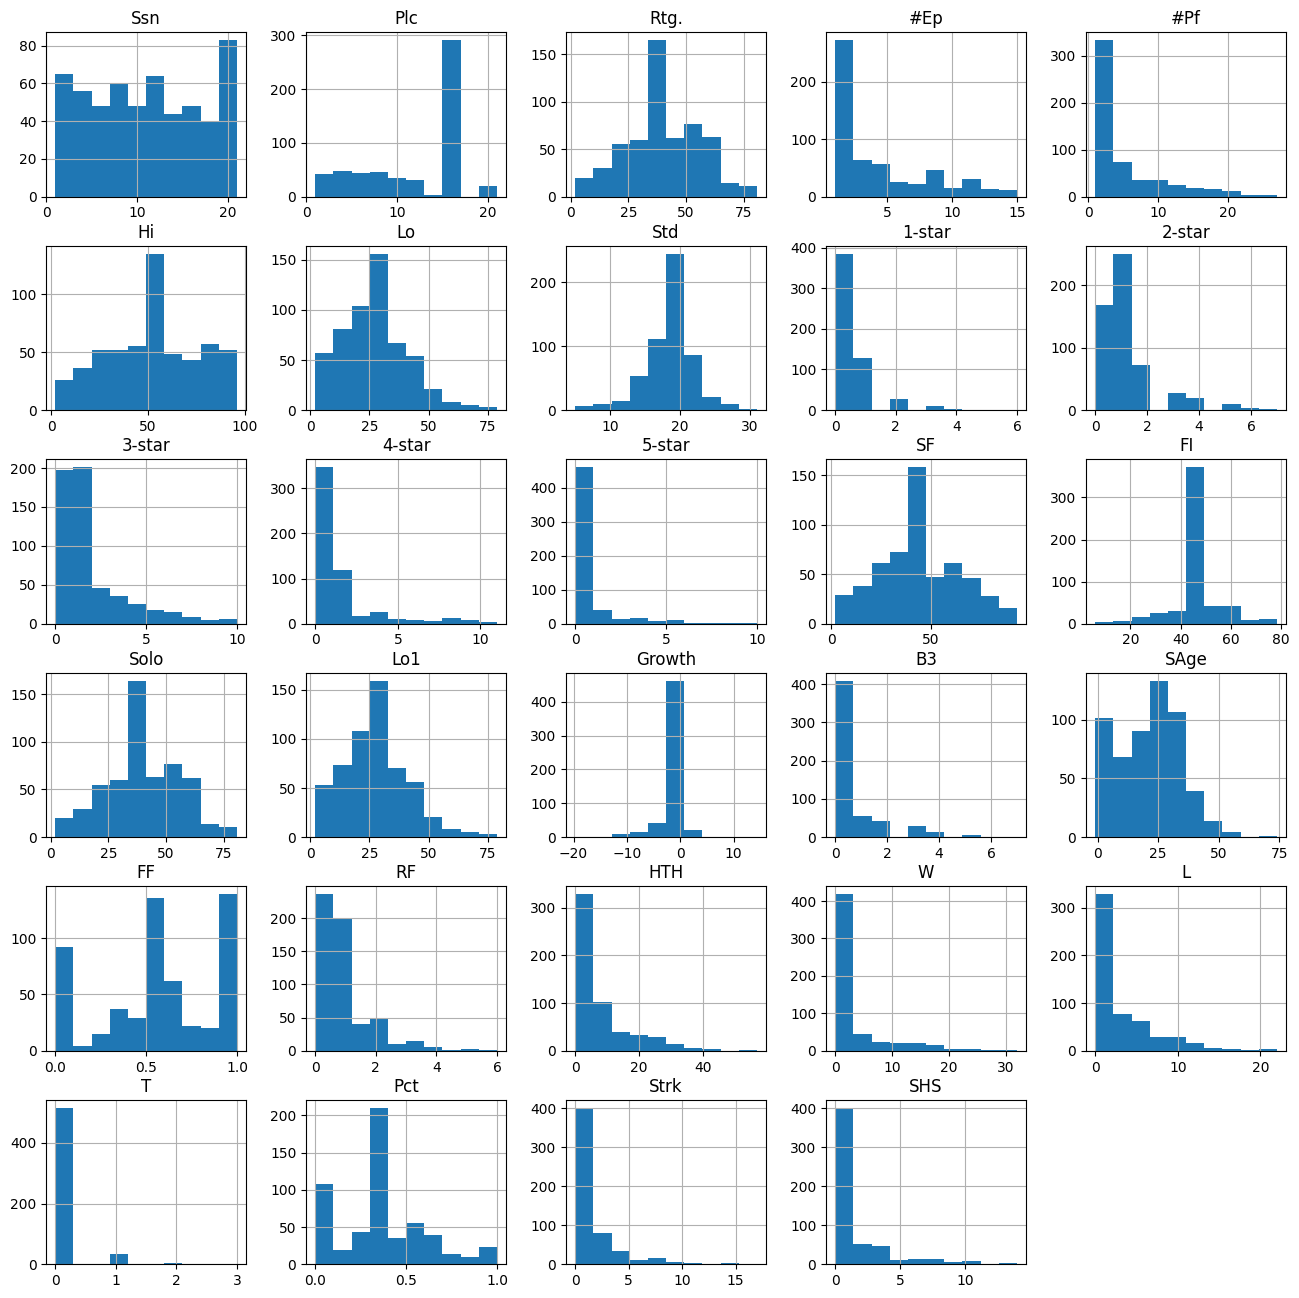

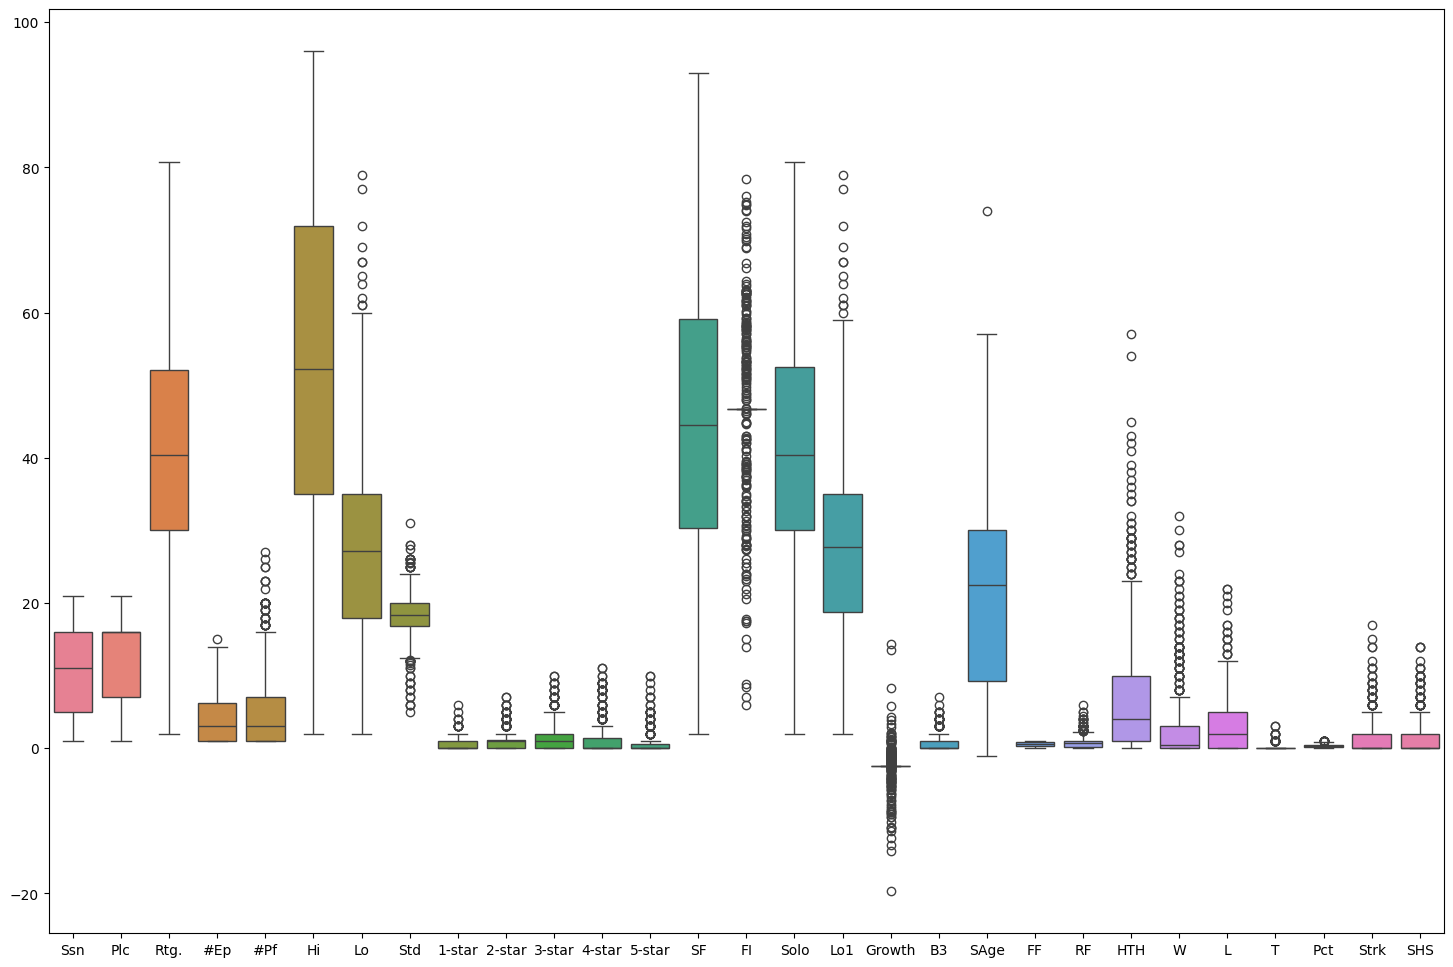

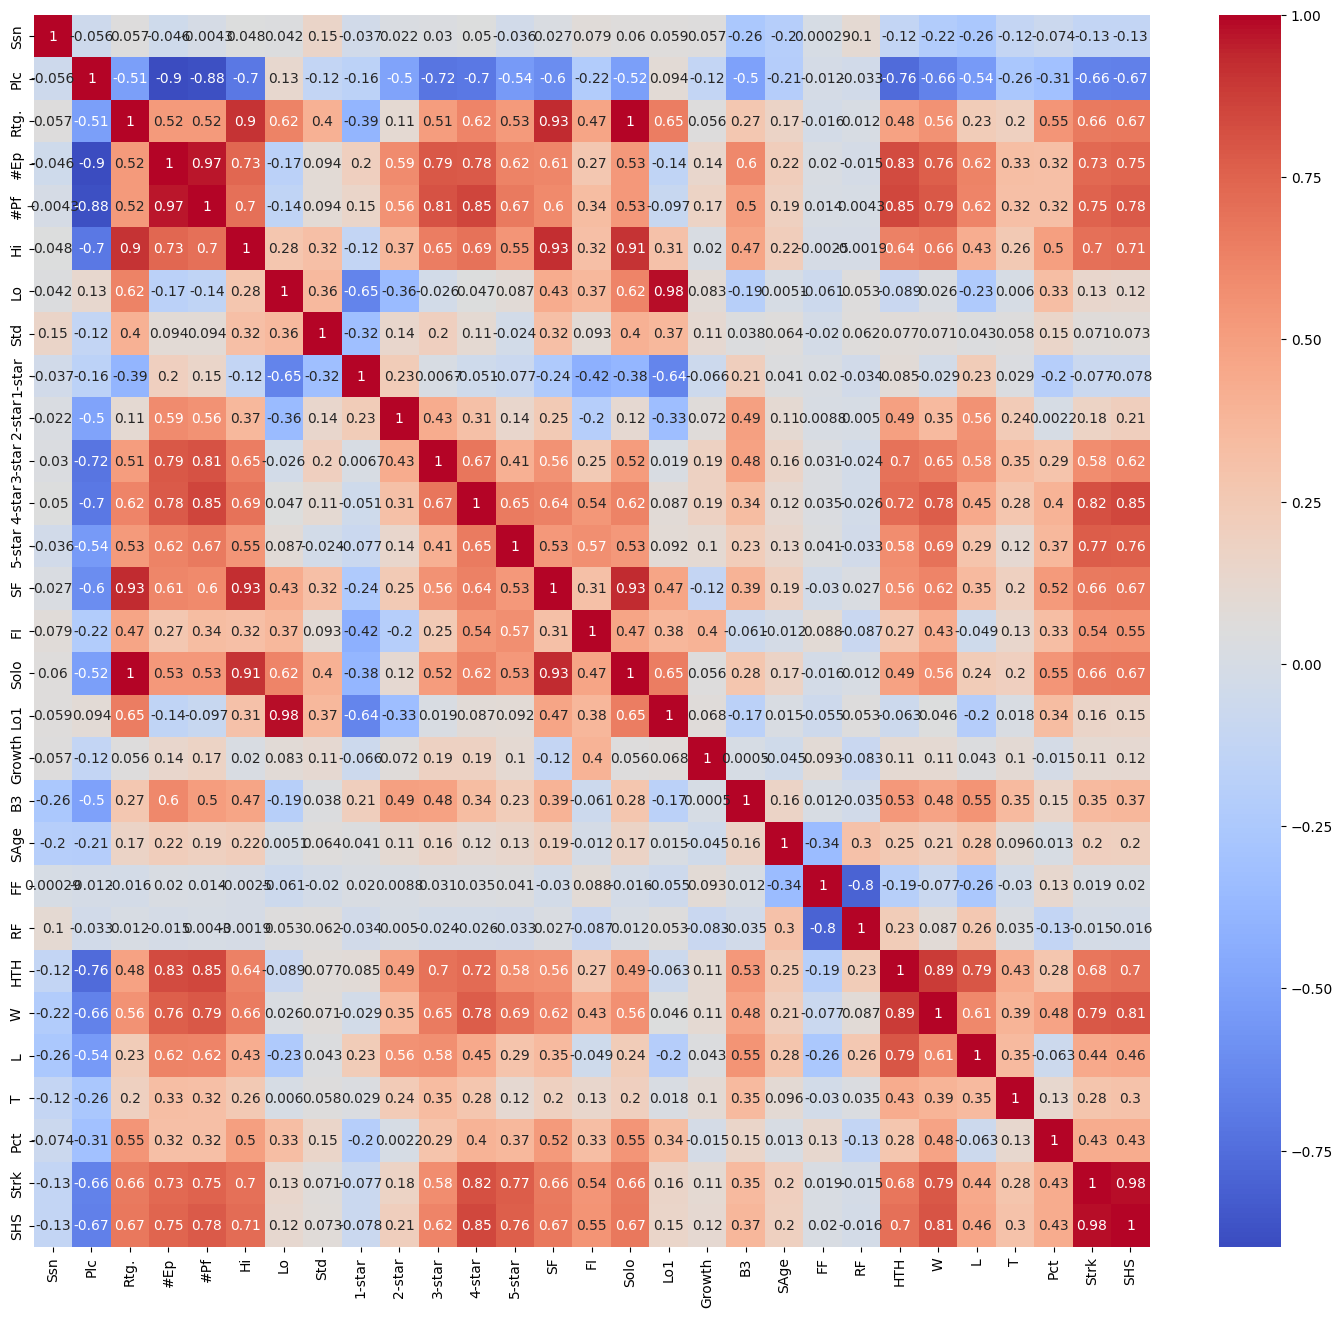

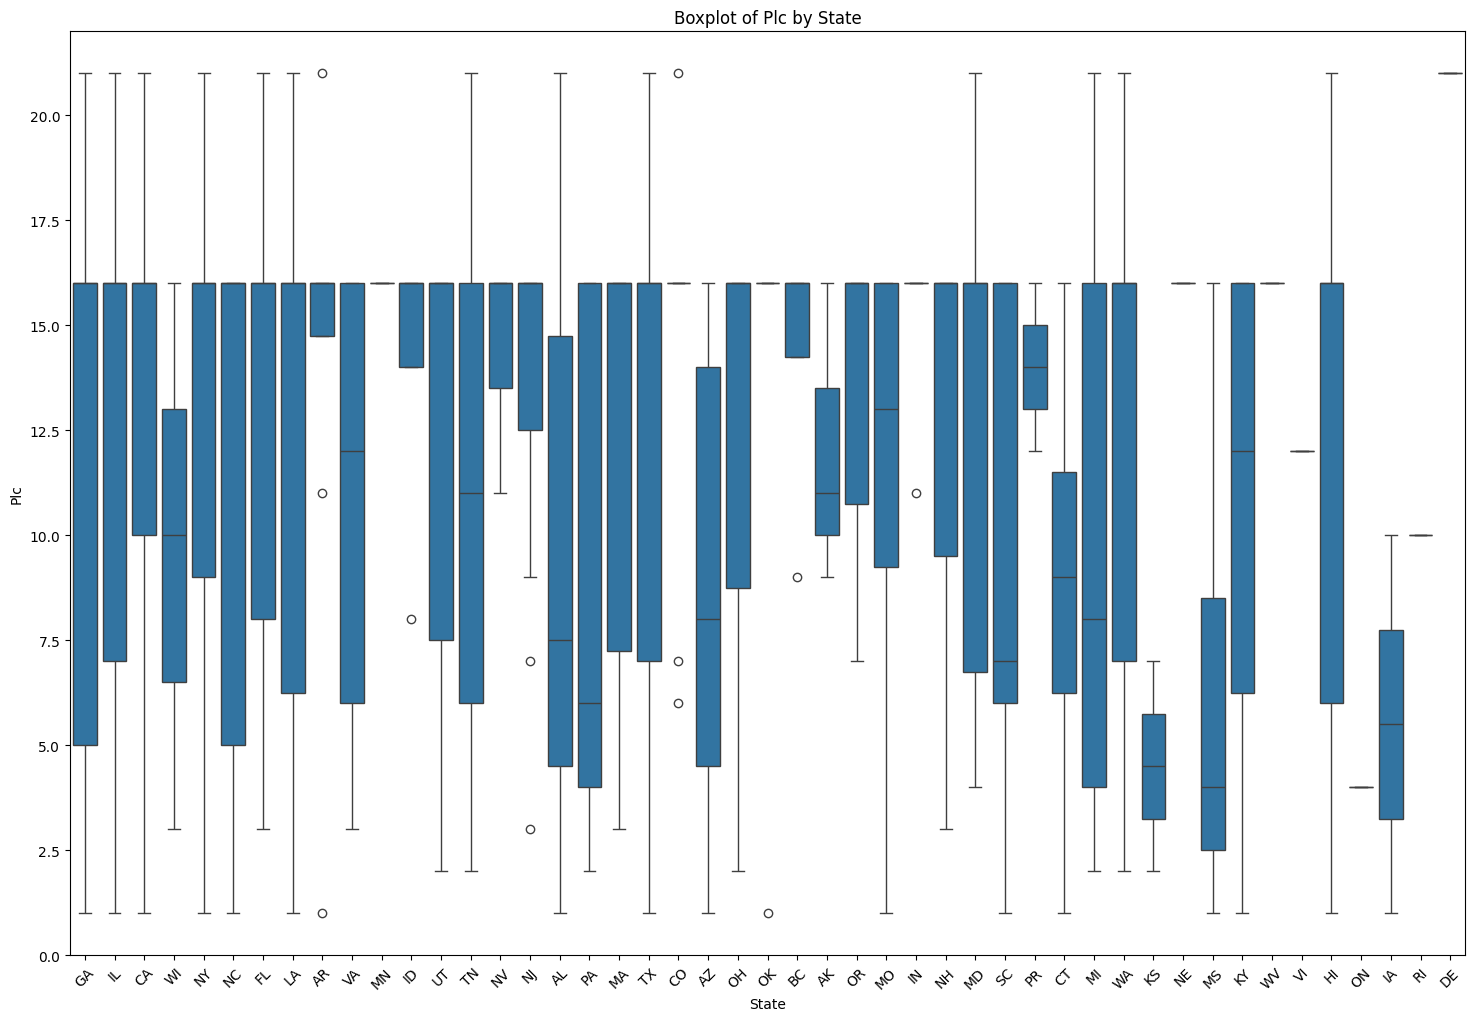

In [42]:
# Summary Statistics
summary_stats = data.describe()
print(summary_stats)

# Data Visualization
# Histogram of numerical variables
fig, axes = plt.subplots(figsize=(16, 16))
data.hist(ax=axes)
plt.show()

# Boxplot of numerical variables
fig, axes = plt.subplots(figsize=(18, 12))
sns.boxplot(data=data, ax=axes)
plt.show()

# Correlation Analysis
non_numerical = data.drop(columns=['ID', 'Name', 'Hometown', 'State'])
correlation_matrix = non_numerical.corr()
fig, axes = plt.subplots(figsize=(18, 16))  # Adjust the figsize as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=axes)
plt.show()

# Plot Plc variable against State
plt.figure(figsize=(18, 12))
sns.boxplot(x='State', y='Plc', data=data)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.title('Boxplot of Plc by State')
plt.xlabel('State')
plt.ylabel('Plc')
plt.show()

### Machine Learning

Machine learning involves using algorithms to learn from data and make predictions. In this step, we will build a predictive linear regression model to determine which features most significantly impact contestant performance.

#### Prepare the Data

In [43]:
# Drop non-numeric columns that are not relevant for regression analysis
data_numeric = data.drop(columns=['ID', 'Name', 'Hometown'])

# Separate features and target variable before encoding
X = data_numeric.drop(columns=['Plc'])
y = data_numeric['Plc']

# OneHotEncode 'State' column
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), ['State'])], remainder='passthrough')
X_encoded = ct.fit_transform(X)

# Convert the encoded data back to a DataFrame
encoded_feature_names = ct.get_feature_names_out()
X_encoded = pd.DataFrame(X_encoded, columns=encoded_feature_names)

# Ensure target variable is numeric
y = pd.to_numeric(y, errors='coerce')

#### Split the Data

In [44]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

#### Build and Train the Model

In [45]:
# Create and train the linear regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

#### Evaluate the Model

In [46]:
# Make predictions on the test set
y_pred = regressor.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
n = len(y_test)
k = X_train.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1)) / (n - k - 1)
mse = np.mean((y_test - y_pred)**2)

print(f"R^2: {r2}")
print(f"Adjusted R^2: {adjusted_r2}")
print(f"Mean Squared Error: {mse}")

R^2: 0.8339028969454901
Adjusted R^2: 0.48786726558192794
Mean Squared Error: 5.283964090921595


The R^2 value indicates that 83.4% of the variance in the dependent variable (Plc) can be explained by the independent variables in your model.
The large discrepancy between R^2 and Adjusted R^2 suggests that there might be a large number of predictors in the model, many of which may not contribute significantly to explaining the variance. Adjusted R^2 penalizes for the number of predictors, which results in a much lower value.
The Mean Squared Error is the average squared difference between the observed actual outcomes and the predicted outcomes. Lower values indicate better fit, although interpretation depends on the scale of your target variable.

#### Feature Selection

Feature selection is the process of identifying the most relevant features for the model. We will use the Sequential Feature Selector (SFS) to select the best features for our linear regression model.

In [47]:
# Perform Sequential Feature Selection
sfs = SequentialFeatureSelector(regressor, k_features='best', forward=True, scoring='r2', cv=5)
sfs = sfs.fit(X_train, y_train)

# Get the selected features
selected_features = list(sfs.k_feature_names_)
print(f"Selected features: {selected_features}")

# Refit the model with selected features
X_train_selected = sfs.transform(X_train)
X_test_selected = sfs.transform(X_test)

regressor.fit(X_train_selected, y_train)
y_pred_selected = regressor.predict(X_test_selected)

# Evaluate the model with selected features
r2_selected = r2_score(y_test, y_pred_selected)
n_selected = len(y_test)
k_selected = X_train_selected.shape[1]
adjusted_r2_selected = 1 - ((1 - r2_selected) * (n_selected - 1)) / (n_selected - k_selected - 1)
mse_selected = np.mean((y_test - y_pred_selected)**2)

print(f"R^2 (selected features): {r2_selected}")
print(f"Adjusted R^2 (selected features): {adjusted_r2_selected}")
print(f"Mean Squared Error (selected features): {mse_selected}")

Selected features: ['encoder__State_AK', 'encoder__State_AR', 'encoder__State_DE', 'encoder__State_FL', 'encoder__State_KS', 'encoder__State_KY', 'encoder__State_MD', 'encoder__State_MI', 'encoder__State_MN', 'encoder__State_MS', 'encoder__State_NY', 'encoder__State_OK', 'encoder__State_OR', 'encoder__State_PA', 'encoder__State_PR', 'remainder__Ssn', 'remainder__#Ep', 'remainder__#Pf', 'remainder__1-star', 'remainder__2-star', 'remainder__3-star', 'remainder__4-star', 'remainder__5-star', 'remainder__SF', 'remainder__FI', 'remainder__Lo1', 'remainder__Growth', 'remainder__FF', 'remainder__Strk', 'remainder__SHS']
R^2 (selected features): 0.833345048085347
Adjusted R^2 (selected features): 0.7716209918206607
Mean Squared Error (selected features): 5.301710657784897


The R^2 value is very close to the R^2 of the full model, indicating that the selected subset of features explains almost as much variance as the full set of features.
The Adjusted R^2 is significantly higher than that of the full model. This indicates that the selected features provide a better balance between model complexity and explanatory power.
The new MSE is very close to the MSE of the full model, suggesting that the model's predictive performance has not deteriorated significantly despite using fewer features.

In [49]:
# Print out the coefficient values of the linear regression model
selected_coefficients = regressor.coef_
print("Coefficients of the selected features:")
for feature, coefficient in zip(selected_features, selected_coefficients):
    print(f"{feature}: {coefficient}")

Coefficients of the selected features:
encoder__State_AK: -1.3521798859804595
encoder__State_AR: -0.3456772782603249
encoder__State_DE: 4.4931832503376645
encoder__State_FL: 0.5473394198289014
encoder__State_KS: -7.2038240854482405
encoder__State_KY: -0.7094686758698713
encoder__State_MD: -0.8674826134111204
encoder__State_MI: 1.896254798044292
encoder__State_MN: 1.1908739234889338
encoder__State_MS: -2.037918921782033
encoder__State_NY: -0.3602679864307459
encoder__State_OK: 0.7176700169840117
encoder__State_OR: 1.4381380926475484
encoder__State_PA: -2.138257686630839
encoder__State_PR: 0.868770098600004
remainder__Ssn: -0.09332511521009544
remainder__#Ep: -0.7535011440230682
remainder__#Pf: -0.8066100523616878
remainder__1-star: 0.47871148617716175
remainder__2-star: 0.82884570225091
remainder__3-star: 0.4071295916474788
remainder__4-star: 0.7038548231385887
remainder__5-star: 0.7635814620917845
remainder__SF: -0.060218057345004565
remainder__FI: 0.05424369539022983
remainder__Lo1: 0

### Insights

##### Regional Disparities in Performance

The analysis revealed significant variations in contestant performance based on their state of origin. The regression revealed that a contestant coming from certain states have a greater chance of success on the show, such as Delaware. Conversely, contestants coming from states such as Kansas, Mississippi and Pennsylvania are more likely to leave the show earlier than others. 

##### Importance of Feature Selection

Sequential Feature Selection proved instrumental in identifying the most relevant features for predicting contestant performance. By systematically evaluating different feature subsets, SFS enabled the construction of a more concise and interpretable model without sacrificing predictive accuracy. This emphasizes the importance of feature selection techniques in optimizing model performance and reducing overfitting.

##### Implications for Contestants and Producers

Contestants participating in TV show competitions can benefit from a deeper understanding of the factors influencing their final placing. Insights derived from this analysis, such as the significance of regional disparities, can inform contestants' strategies, possibly improving their chances of success. Similarly, producers can leverage these insights to refine casting decisions, tailor competition formats to audience preferences, and enhance the overall appeal of their shows.

In conclusion, the analysis presented in this tutorial offers valuable insights into the dynamics of TV show competitions. By leveraging data science techniques, researchers, contestants, and producers can gain a deeper understanding of the underlying factors driving contestant performance, ultimately contributing to the continued evolution and success of television entertainment.